In [1]:
!pip install -Uq bayeux-ml

In [1]:
import arviz as az
import bayeux as bx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

# Using bayeux with TFP-on-JAX

[More on TensorFlow Probability here](https://www.tensorflow.org/probability/).

We implement a common hierarchical model of the eight schools dataset (Rubin 1981¹), whose details can be seen on the [Stan documentation](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html), [PyMC documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html), [TFP documentation](https://www.tensorflow.org/probability/examples/Eight_Schools), [numpyro documentation](https://num.pyro.ai/en/stable/getting_started.html#a-simple-example-8-schools), among others.

Note that the sections after "Defining bayeux model" are the same no matter how the model was defined.

¹ _Rubin, Donald B. 1981. “Estimation in Parallel Randomized Experiments.” Journal of Educational and Behavioral Statistics 6 (4): 377–401._

In [2]:
num_schools = 8
treatment_effects = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)
treatment_stddevs = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)

In [3]:
@tfd.JointDistributionCoroutineAutoBatched
def tfp_model():
  avg_effect = yield tfd.Normal(0., 10., name='avg_effect')
  avg_stddev = yield tfd.HalfNormal(10., name='avg_stddev')
  school_effects = yield tfd.Sample(
      tfd.Normal(0., 1.), sample_shape=8, name='school_effects')

  yield tfd.Normal(loc=avg_effect + avg_stddev * school_effects,
                   scale=treatment_stddevs, name='observed')

pinned_model = tfp_model.experimental_pin(observed=treatment_effects)

In [4]:
test_point = pinned_model.sample_unpinned(seed=jax.random.PRNGKey(0))
# seed doesn't matter, can also use
# test_point = jax.tree_map(jnp.ones, pinned_model.event_shape)

transform_fn = pinned_model.experimental_default_event_space_bijector()

bx_model = bx.Model(
    log_density=pinned_model.log_prob,
    test_point=test_point,
    transform_fn=transform_fn
)

In [5]:
idata = bx_model.mcmc.blackjax_nuts(seed=jax.random.PRNGKey(0))

az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_effect,6.558,4.070,-1.158,14.122,0.059,0.046,4812.0,2944.0,1.0
avg_stddev,4.644,3.564,0.000,10.954,0.068,0.053,3386.0,2388.0,1.0
school_effects[0],0.343,0.970,-1.393,2.224,0.014,0.015,5158.0,2817.0,1.0
school_effects[1],0.053,0.925,-1.660,1.749,0.011,0.015,6473.0,3184.0,1.0
school_effects[2],-0.139,0.946,-1.907,1.632,0.012,0.015,6105.0,3194.0,1.0
school_effects[3],-0.002,0.916,-1.830,1.585,0.012,0.015,6197.0,3045.0,1.0
school_effects[4],-0.269,0.914,-1.971,1.443,0.013,0.014,5177.0,3118.0,1.0
school_effects[5],-0.144,0.934,-1.879,1.627,0.012,0.016,6209.0,3034.0,1.0
school_effects[6],0.330,0.940,-1.615,1.951,0.014,0.014,4549.0,2771.0,1.0
school_effects[7],0.051,0.971,-1.900,1.758,0.012,0.016,6736.0,2966.0,1.0


StructTuple(
  avg_effect=Array([6.170567 , 6.1705155, 6.170517 , 6.1705117, 6.170514 , 6.170519 ,
           6.1705165, 6.1705165], dtype=float32),
  avg_stddev=Array([10.6252775, 10.625166 , 10.625167 , 10.625158 , 10.625164 ,
           10.625158 , 10.625162 , 10.625166 ], dtype=float32),
  school_effects=Array([[ 0.68687516,  0.09130273, -0.26413926,  0.03767823, -0.3951956 ,
            -0.2348853 ,  0.59038466,  0.14177081],
           [ 0.68643355,  0.09130631, -0.26413608,  0.0376828 , -0.3929356 ,
            -0.23488224,  0.59038836,  0.14177175],
           [ 0.68643355,  0.09130623, -0.2641361 ,  0.03768104, -0.39293566,
            -0.23488232,  0.5903883 ,  0.1417717 ],
           [ 0.68643355,  0.09130645, -0.2644407 ,  0.03768132, -0.39293548,
            -0.23488216,  0.5903885 ,  0.14177178],
           [ 0.68643355,  0.0913064 , -0.26413602,  0.03768126, -0.39293554,
            -0.23488219,  0.5903884 ,  0.14177176],
           [ 0.6864333 ,  0.09130613, -0.26413608

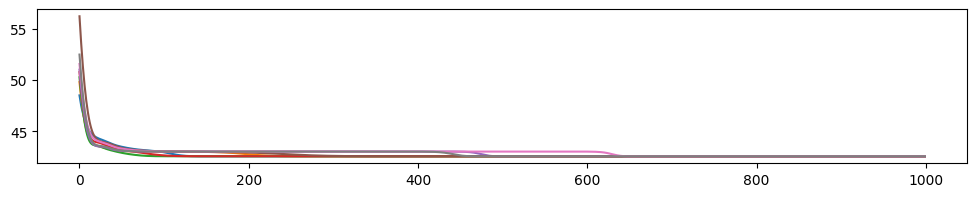

In [6]:
opt_results = bx_model.optimize.optax_adam(seed=jax.random.PRNGKey(0))


fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(opt_results.loss.T)
opt_results.params

StructTuple(
  avg_effect=Array(6.546407, dtype=float32),
  avg_stddev=Array(3.8073668, dtype=float32),
  school_effects=Array([ 0.3435079 ,  0.06276067, -0.13118589,  0.04159814, -0.29985726,
           -0.10515903,  0.39394206,  0.03527481], dtype=float32)
)

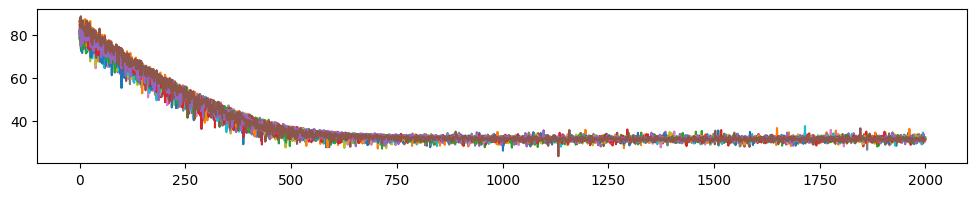

In [7]:
surrogate_posterior, losses = bx_model.vi.tfp_factored_surrogate_posterior(
    seed=jax.random.PRNGKey(0))


fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(losses.T)

draws = surrogate_posterior.sample(100, seed=jax.random.PRNGKey(1))
jax.tree_map(lambda x: jnp.mean(x, axis=(0, 1)), draws)